In [302]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import re

from pathlib import Path
from datetime import datetime
from math import ceil, log10

from matplotlib.axes import Axes
from matplotlib.colors import to_rgba

In [303]:
TEST_DIR = "results"
ONE_TABLE_FILENAME = "one_table_results.txt"
MULTI_TABLE_FILENAME = "multi_table_results.txt"
TIMESTAMP_FORMAT = "%Y-%m-%d_%H:%M:%S.%f"

TEST_BASELINE_MS = 265000

In [304]:
def parse_explain_file(path: str, test_timestamp: str, testing_schema: str) -> list[dict]:
    """
    Parse the results of the tests analyze splitting the file into individual
    test blocks, and then looking for key elements in the text.

    What we are interested in;
        - The planning time,
        - The execution time, and
        - The time of algorithm used.

    The last one becomes tricky to implement since the UNION query uses multiple
    algorithms per part of the UNION, so we'll omit it for now.

    Returns, a list of dictionaries of the data parsed.
    """
    results = []
    
    with open(path, "r", encoding="utf-8") as f:
        text = f.read()

    test_blocks = re.split(r"=+\s*TEST_NAME:", text)[1:]
    for block in test_blocks:
        name_match = re.search(r"(.*?)\n=+", block)
        test_name = name_match.group(1).strip() if name_match else None

        case_blocks = re.split(r"=+\s*TEST_CASE_NUM:", block)[1:]

        for case_block in case_blocks:
            case_match = re.search(r"(\d+)", case_block)
            case_num = int(case_match.group(1)) if case_match else None

            factors_match = re.search(r"({[\d,]*\d})", case_block)
            factors_str = factors_match.group(1).strip("{}") if factors_match else None

            plan_match = re.search(r"Planning Time:\s*([\d.]+)\s*ms", case_block)
            planning_time = float(plan_match.group(1)) if plan_match else None

            exec_match = re.search(r"Execution Time:\s*([\d.]+)\s*ms", case_block)
            execution_time = float(exec_match.group(1)) if exec_match else None

            results.append({
                "schema": testing_schema,
                "timestamp": datetime.strptime(test_timestamp, TIMESTAMP_FORMAT),
                "name": test_name,
                "case_num": case_num,
                "factors": factors_str,
                "total_time_ms": planning_time + execution_time
            })

    return results

In [305]:
def collect_and_parse_data() -> list[list[dict]]:
    """
    Loop through the test directory, collect each folder name as the timestamp.
    Return the entirety of all the parsed data in the directory.
    """
    folder = Path(TEST_DIR)

    results = []
    for item in folder.iterdir():
        if not item.is_dir():
            continue
        
        # Add the results from both schemata
        results += parse_explain_file(item / ONE_TABLE_FILENAME, item.name, "One Table")
        results += parse_explain_file(item / MULTI_TABLE_FILENAME, item.name, "Multi Table")
    
    return results

In [306]:
def clean_names(name: str) -> str:
    """
    Helper function used to sanitize the column names for visualizing.
    """
    return name.replace('_', ' ').replace('num', 'Number').replace('ms','').strip().title()

def ms_to_s(val: str, pos:int) -> str:
    """
    Helper callback used to convert ms to s
    by Str formatter.
    """
    return f'{val/1000}s'

def display_summary_stats(df:pd.DataFrame) -> None:
    print("\nOverall statistic from all tests:")
    print("\nTable Averages")
    print(df.groupby(['schema'])['total_time_ms'].mean())
    print("\nTable Maximums")
    print(df.groupby(['schema'])['total_time_ms'].max())
    print("\nTable Minimums")
    print(df.groupby(['schema'])['total_time_ms'].min())
    print()

In [311]:
plt.style.use('ggplot')

plt.rcParams.update({
    ''
    'font.size': 11,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'lines.linewidth': 2,
    'figure.facecolor': 'white',
    'axes.facecolor': to_rgba('lightsteelblue', 0.6),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'axes.labelcolor': 'black',
})

colours = {
    'C++ Parser': 'red',
    'One Table': 'blue',
    'Multi Table': 'darkorange',
}

In [321]:
def visualize(
        df:pd.DataFrame,
        # y_name:str,
        gb_col:str,
        val_col:str,
        baseline:bool = True,
        y_label:bool = True,
        legend:bool = True,
        agg_type:str = 'mean',
        ax:Axes=None,
    ) -> None:
    """
    Function created to visualize a variable specified.
    Uses a group by operation to group the schemas together,
    then it's aggregated by the passed in aggregation function,
        This must be a Pandas series function.

    There is a special case to show the baseline value if required.
        When this is false, it will omit showing the line,
        and the legend will also be omitted.

    This is meant to be used inside a mpl axis, the last
    argument shows this. If it is None, a new one is created.
    """
    if ax is None:
        ax = plt.subplot()

    for schema, group in df.groupby('schema'):
        avg_by_factors = group\
            .groupby(gb_col)[val_col]\
            .agg(agg_type)
        
        ax.plot(
            avg_by_factors.index, 
            avg_by_factors.values, 
            label=schema,
            color=colours.get(schema, 'black'),
            marker='.'
        )

    if baseline:
        ax.axhline(
            y=TEST_BASELINE_MS,
            color=colours.get('baseline', 'red'),
            linestyle='--',
            label='C++ Parser'
        )

    if legend:
        ax.legend(
            bbox_to_anchor=(1, 0.90),
            frameon=True,
            edgecolor='black',
            framealpha=0.8,
            facecolor='white',
        )

    if y_label:
        ax.set_ylabel(clean_names(avg_by_factors.name))

    if max(len(str(label)) for label in df[gb_col].unique()) > 5:
        ax.tick_params(axis='x', rotation=45)

    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))    # Keeps the values as integers
    ax.yaxis.set_major_formatter(ticker.FuncFormatter(ms_to_s))     # Converts the displayed amount to seconds from ms

In [314]:
def create_grid(
        df:pd.DataFrame,
        title:str,
        subtitle:str,
        gb_col:str,
        val_col:str,
        improvement:bool = False,
    ) -> None:
    """
    Wrapper function for creating a grid of two visualizations.
    Creates one with a y title, legend, and baseline, and the second
    one does not include those attributes.

    @args:
        - df: A pandas dataframe with the data.
        - title: Display at the top of figure.
        - subtitle: Visualization description.
        - gb_col: Column name to group by.
        - val_col: Column name to aggregate.
        - improvement: If you are visualizing an improvement metric
    """

    if improvement:
        fig, axes = plt.subplots(1, 1, figsize=(5, 4))
        visualize(
            df=df,
            gb_col=gb_col,
            val_col=val_col,
            baseline=False,
            ax=axes
        )
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        visualize(
            df=df,
            gb_col=gb_col,
            val_col=val_col,
            ax=axes[0]
        )
        visualize(
            df=df,
            gb_col=gb_col,
            val_col=val_col,
            baseline=False,
            y_label=False,
            legend=False,
            ax=axes[1]
        )

    fig.suptitle(title, fontsize=18, x=0, ha='left')
    fig.text(0, 0.875, subtitle, ha='left', fontsize=12, color='#2b2b2b')
    fig.subplots_adjust(top=0.85)

Analyzing database tests ran.
Comparing against the baseline of 265,000ms.


,schema,timestamp,name,case_num,factors,total_time_ms,improvement_ms,improvement_percent,num_of_factors,min_ord_mag10,max_ord_mag10,balanced
0,One Table,2025-11-25 05:14:41.451604,1_primes.txt,1,5,19532.867,245467.133,0.926291,1,1,1,Balanced
1,Multi Table,2025-11-25 05:14:41.451604,1_primes.txt,1,5,16942.163,248057.837,0.936067,1,1,1,Balanced
2,One Table,2025-11-25 05:14:41.451604,1_primes.txt,2,11,56728.425,208271.575,0.785930,1,2,2,Balanced
3,Multi Table,2025-11-25 05:14:41.451604,1_primes.txt,2,11,43712.530,221287.470,0.835047,1,2,2,Balanced
4,One Table,2025-11-25 05:14:41.451604,1_primes.txt,3,29,57022.828,207977.172,0.784820,1,2,2,Balanced



Overall statistic from all tests:

Table Averages
schema
Multi Table    17044.038728
One Table       5660.660411
Name: total_time_ms, dtype: float64

Table Maximums
schema
Multi Table    50673.571
One Table      57427.091
Name: total_time_ms, dtype: float64

Table Minimums
schema
Multi Table    15367.511
One Table          3.435
Name: total_time_ms, dtype: float64



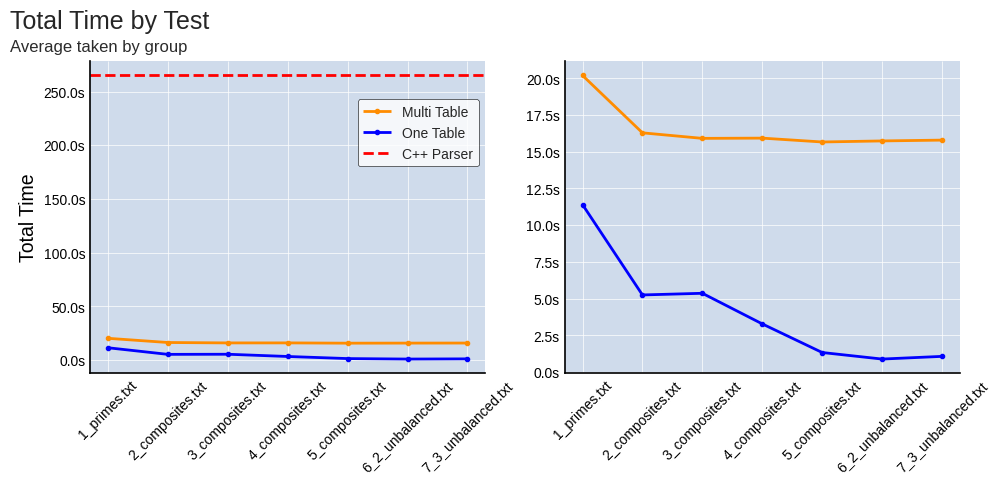

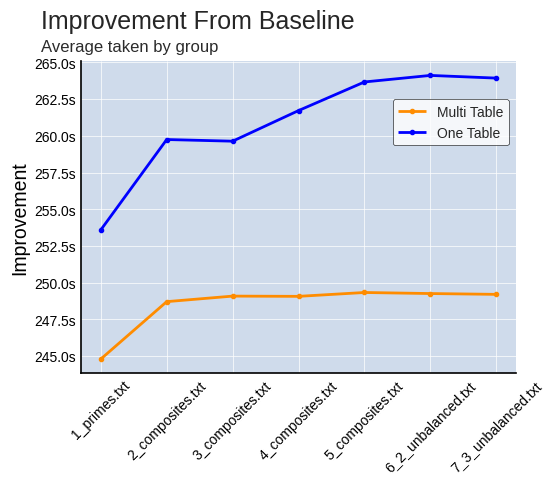

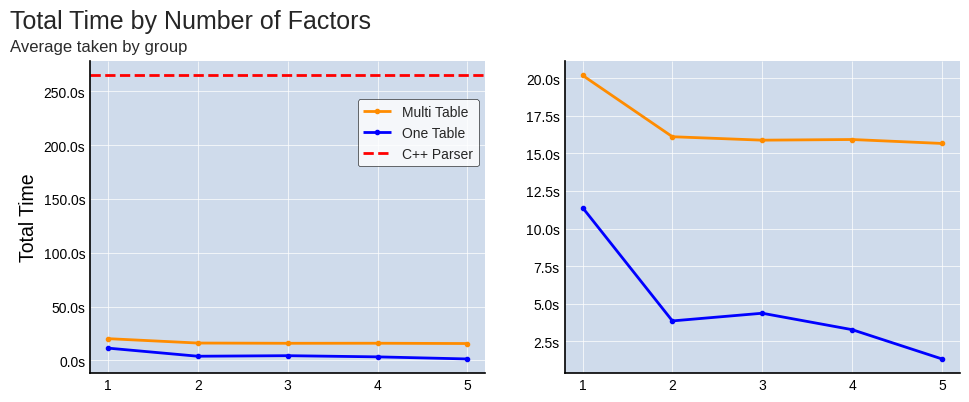

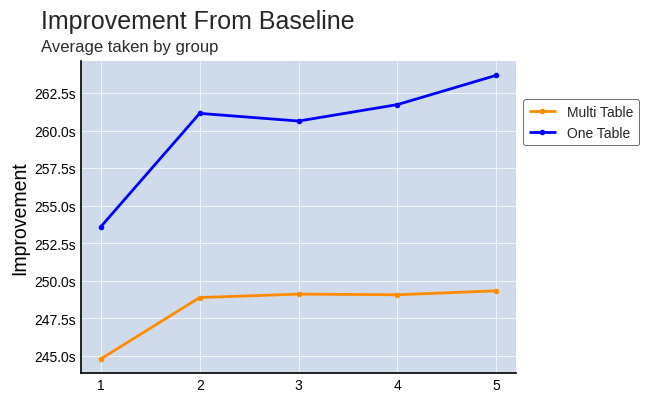

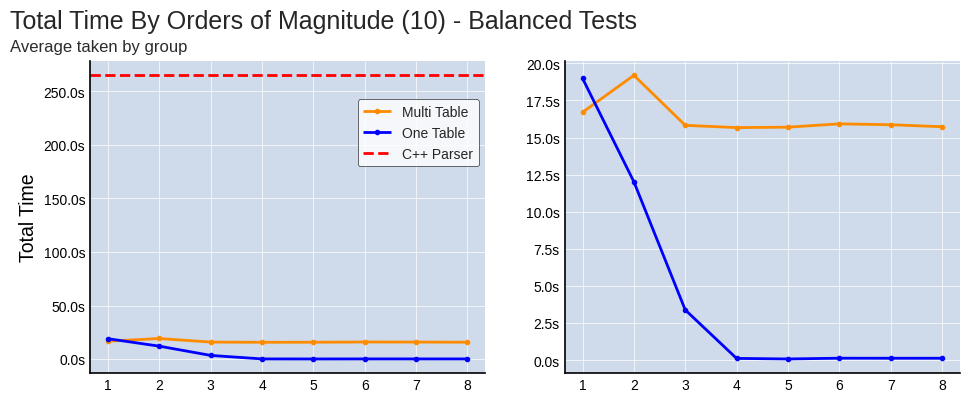

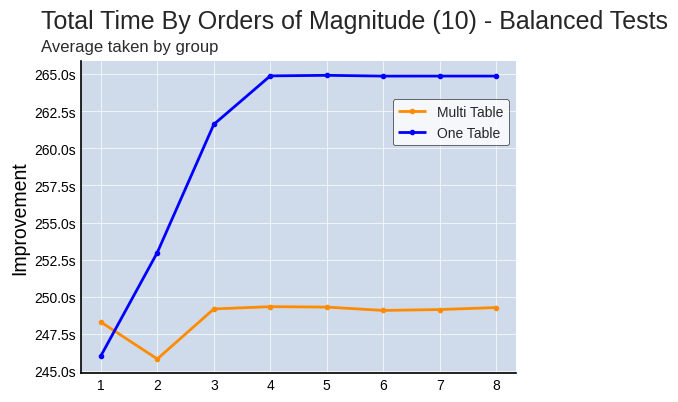

In [323]:
def main():
    """
    This script will:
        - Parse the data from the explain analyze queries. The name of the
          directory indicates when the test was ran. Everything else will be
          collected from inside the file itself.
        - Organize the data onto a pandas dataframe with appropriate typing.
          This step also adds additional columns to the dataframe for
          analysis.
        - Visualize the results, comparing them against the baseline of
          4m:25s or 265000ms.

    The visualizations will be outputted onto PNGs to be used in the final
    report. The console will also output some summary statistics to give
    the user a brief preview of how the tests faired.
    """
    print("Analyzing database tests ran.")
    print(f"Comparing against the baseline of {TEST_BASELINE_MS:,}ms.")
    results_df = pd.DataFrame(collect_and_parse_data())

    # Add calculated columns for analysis
    results_df["improvement_ms"] = TEST_BASELINE_MS - results_df["total_time_ms"]
    results_df["improvement_percent"] = results_df["improvement_ms"] / TEST_BASELINE_MS
    results_df["num_of_factors"] = results_df["factors"].str.count(",") + 1

    # Get the min magnitude and max magnitude of each number in the tests
    results_df["min_ord_mag10"] = results_df["factors"].apply(
        lambda x: ceil(log10(min([int(p) for p in x.split(",")])))
    )
    results_df["max_ord_mag10"] = results_df["factors"].apply(
        lambda x: ceil(log10(max([int(p) for p in x.split(",")])))
    )

    # Balanced if the order of magnitudes equal from min to max
    results_df["balanced"] = results_df.apply(
        lambda x: "Balanced" if x["min_ord_mag10"] == x["max_ord_mag10"] else "Unbalanced",
        axis=1
    )

    # Sort the table by timestamp (asc), name (asc), case_num (asc), schema (asc)
    results_df.sort_values(
        ["timestamp", "name", "case_num", "schema"], 
        ascending=[True, True, True, False], 
        ignore_index=True,
        inplace=True, 
    )

    display(results_df.head())

    display_summary_stats(results_df)

    # Create some visualizations!
    create_grid(
        df=results_df,
        title="Total Time by Test",
        subtitle="Average taken by group",
        gb_col='name',
        val_col='total_time_ms'
    )

    create_grid(
        df=results_df,
        title="Improvement From Baseline",
        subtitle="Average taken by group",
        gb_col='name',
        val_col='improvement_ms',
        improvement=True
    )

    create_grid(
        df=results_df,
        title="Total Time by Number of Factors",
        subtitle="Average taken by group",
        gb_col='num_of_factors',
        val_col='total_time_ms'
    )

    create_grid(
        df=results_df,
        title="Improvement From Baseline",
        subtitle="Average taken by group",
        gb_col='num_of_factors',
        val_col='improvement_ms',
        improvement=True
    )

    # For all the balanced tests, group by orders of magnitude
    create_grid(
        df=results_df.query("balanced == 'Balanced'"),
        title="Total Time By Orders of Magnitude (10) - Balanced Tests",
        subtitle="Average taken by group",
        gb_col='min_ord_mag10',
        val_col='total_time_ms'
    )

    create_grid(
        df=results_df.query("balanced == 'Balanced'"),
        title="Total Time By Orders of Magnitude (10) - Balanced Tests",
        subtitle="Average taken by group",
        gb_col='min_ord_mag10',
        val_col='improvement_ms',
        improvement=True
    )


if __name__ == "__main__":
    main()